Importing Libraries

In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

Function to extract features

In [5]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

Selecting emotions for the model(Data preprocessing)

In [6]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions=['calm', 'happy', 'fearful', 'disgust']
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\dataset\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    # Convert labels to numerical values
    le = LabelEncoder()
    y = to_categorical(le.fit_transform(y))
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

Splitting the dataset

In [7]:
# Load data
x_train, x_test, y_train, y_test = load_data(test_size=0.25)
# Reshape features to 3D tensor
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

Building LSTM Model

In [8]:
# Build LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training the model

In [11]:
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3532 - accuracy: 0.8733
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.3414 - accuracy: 0.8628
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 0.3892 - accuracy: 0.8576
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.3351 - accuracy: 0.8750
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2766 - accuracy: 0.8976
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.3244 - accuracy: 0.8872
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3418 - accuracy: 0.8802
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 0.3415 - accuracy: 0.8542
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2835 - accuracy: 0.9028
Epoch 10/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2803 - accuracy: 0.8906
Epoch 11

Evaluating the model

In [12]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

6/6 [==============================] - 0s 5ms/step - loss: 1.0475 - accuracy: 0.7240
Accuracy: 72.40%


Summary of model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            158208    
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

Plotting graph

Epoch 1/100
18/18 [==============================] - 0s 16ms/step - loss: 0.2052 - accuracy: 0.9253 - val_loss: 0.9951 - val_accuracy: 0.7240
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1760 - accuracy: 0.9479 - val_loss: 1.0221 - val_accuracy: 0.7552
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1575 - accuracy: 0.9497 - val_loss: 1.0515 - val_accuracy: 0.7500
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1881 - accuracy: 0.9306 - val_loss: 1.1384 - val_accuracy: 0.7396
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1969 - accuracy: 0.9253 - val_loss: 1.0690 - val_accuracy: 0.7083
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1958 - accuracy: 0.9219 - val_loss: 0.9160 - val_accuracy: 0.7708
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1763 - accuracy: 0.9444 - val_loss: 0.9836 - val_accuracy: 0.7396
Epoch 8/100


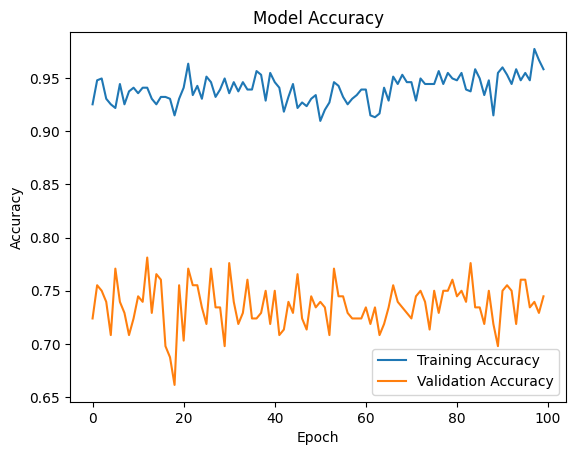

In [14]:
# Train model and save history
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Confusion matrix and heat map

6/6 [==============================] - 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

        calm       0.93      0.75      0.83        57
       happy       0.70      0.73      0.71        48
     fearful       0.66      0.84      0.74        37
     disgust       0.69      0.68      0.69        50

    accuracy                           0.74       192
   macro avg       0.75      0.75      0.74       192
weighted avg       0.76      0.74      0.75       192



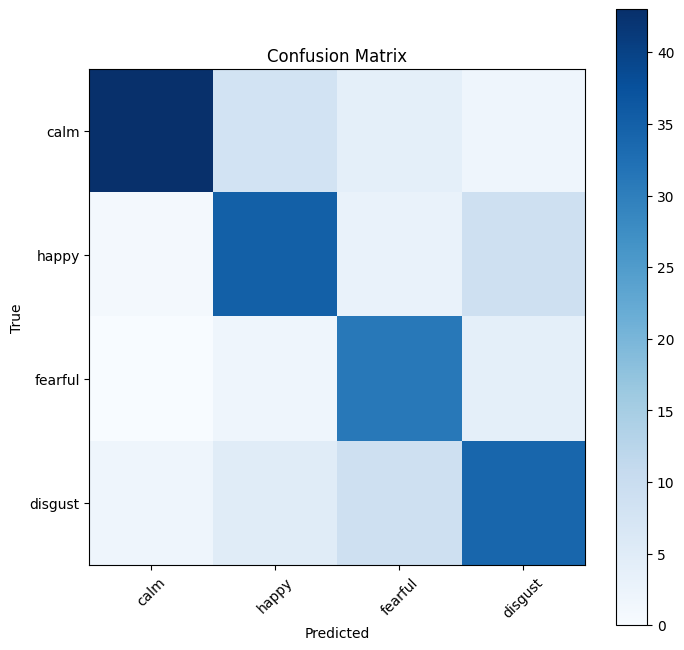

In [15]:
# Predict classes for test set
y_pred_probs = model.predict(x_test)
y_pred_class = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoding to class labels
y_test_class = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test_class, y_pred_class)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = observed_emotions
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Print classification report
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class, target_names=classes))

plt.show()